<a href="https://colab.research.google.com/github/dagyaom/Python_Practice/blob/main/%EC%95%99%EC%83%81%EB%B8%94_%EB%AA%A8%EB%8D%B8_%EC%97%B0%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boosting 사용하기
- 한 트리를 깊게 학습시키면 과적합이 발생하기 때문에 배깅, 부스팅 앙상블 모델을 사용해서 과적합을 피한다. 
- 트리모델 : non-linear(비선형), non-monotonic(비단조), 특성간 상호작용이 존재하는 데이터 학습에 적용하기 좋음
- 랜덤포레스트는 하이퍼 파라미터에 상대적으로 덜 민감한게 특징적. 
- 그래디언트 부스팅은 하이퍼파라미터 셋팅에 따라 랜덤포레스트보다 더 좋은 예측성능을 보여준다. 

# 부스팅, 배깅 차이점
- 둘다 트리 앙상블 모델이지만, 트리를 만드는 방법에 차이가 있음.
- 랜덤포레스트 : 각 트리를 독립적으로 만든다. , 부스팅 : 이전에 만들어진 트리에 영향을 받는 다음 트리
- Adaboost : weak learners가 만들어질 때 잘못 분류되는 관측치에 가중치를 줌. 그리고 다음 트리에서 이전에 잘못 분류된 관측치가 더 많이 샘플링되게 하여 그 관측치를 분류함.
- Gradient : 회귀, 분류 둘다 사용가능한 모델. Adaboost와 유사하지만 비용함수(loss function)을 최적화한다.(샘플의 가중치를 조정하는 대신 잔차(residual)을 학습하도록 함. --> 잔차가 더 큰 데이터를 더 학습하도록 한다. 경사하강법)

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 타겟을 정합니다.
target = 'vacc_seas_f'
# 학습데이터 features, labels 를 병합합니다.
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')

# 80/20 비율로 학습/테스트 데이터를 분리합니다.
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    dels = [col for col in df.columns if ('employment' in col or 'h1n1' in col)]
    df.drop(columns=dels, inplace=True)
        
    return df

train = engineer(train)
val = engineer(val)
test = engineer(test)

In [2]:
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [3]:
pip install category-encoders

     |████████████████████████████████| 80 kB 6.1 MB/s 


In [5]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
from sklearn.metrics import classification_report
# train 학습, 검증셋 정확도
pipe.fit(X_train, y_train)
print('검증 정확도', pipe.score(X_val, y_val))

print(classification_report(y_val, pipe.predict(X_val)))


검증 정확도 0.7526983750444787
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      4608
           1       0.74      0.70      0.72      3823

    accuracy                           0.75      8431
   macro avg       0.75      0.75      0.75      8431
weighted avg       0.75      0.75      0.75      8431



## XGBoost 
- XGBClassifier
- 랜덤포레스트보다 하이퍼파라미터 튜닝에 민감하다. 
- Early Stopping을 사용해서 과적합을 피해보자. 

In [7]:
from xgboost import XGBClassifier

pipe2 = make_pipeline(
OrdinalEncoder(),
SimpleImputer(strategy='median'),
XGBClassifier(n_estimators=200
             , random_state=2
             , n_jobs =-1
             , max_depth=7
             , learning_rate=0.2))

pipe2.fit(X_train,y_train);

In [8]:
from sklearn.metrics import accuracy_score
y_pred = pipe2.predict(X_val)

In [9]:
print('검증정확도 : ', accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
# 쬐끔 나아졌네.

검증정확도 :  0.7601707982445736
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      4608
           1       0.74      0.72      0.73      3823

    accuracy                           0.76      8431
   macro avg       0.76      0.76      0.76      8431
weighted avg       0.76      0.76      0.76      8431



## Early Stopping :  n_estimators의 최적화.
- n_estimators의 최적화를 위해 GridsearchCV대신 early stopping를 사용함.


In [10]:
# vc = y_train.value_counts().tolist()
# vc

In [11]:
# ratio = float(vc[0]/vc[1])
# ratio

# #sum(negative instances) / sum(positive instances)

In [12]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators = 1000,
    max_depth=7,
    learning_rate=0.2,
    # scale_pos_weight=ratio,  #imbalance데이터의 경우 적용
    n_jobs=-1
)



eval_set = [(X_train_encoded, y_train),
           (X_val_encoded, y_val)]   #이것만 넣어도 작동이 되는데, 위애 train까지 같이 넣는건 무슨 의도지?(마지막 줄만 작동된다고 하던데?)
# 아, 위에꺼 지우고 작동해 볼것.
model.fit(X_train_encoded, y_train,
         eval_set=eval_set,  # 메트릭이 계산할 검증세트로, 튜플 쌍 목록이어야 함. 
         eval_metric='error',   #모델의 평가지표
         early_stopping_rounds=50 #최대한 몇개의 트리를 완성해볼까?
         )


# xgboost 파라미터 : https://xgboost.readthedocs.io/en/latest/parameter.html
# xg부스트 하이퍼파라미터 : https://hwi-doc.tistory.com/entry/%EC%9D%B4%ED%95%B4%ED%95%98%EA%B3%A0-%EC%82%AC%EC%9A%A9%ED%95%98%EC%9E%90-XGBoost 

[0]	validation_0-error:0.239777	validation_1-error:0.248013
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.235092	validation_1-error:0.245641
[2]	validation_0-error:0.229398	validation_1-error:0.242676
[3]	validation_0-error:0.228301	validation_1-error:0.241727
[4]	validation_0-error:0.225751	validation_1-error:0.238999
[5]	validation_0-error:0.22409	validation_1-error:0.238169
[6]	validation_0-error:0.222578	validation_1-error:0.236627
[7]	validation_0-error:0.220977	validation_1-error:0.236271
[8]	validation_0-error:0.220888	validation_1-error:0.237338
[9]	validation_0-error:0.218931	validation_1-error:0.236271
[10]	validation_0-error:0.216914	validation_1-error:0.234848
[11]	validation_0-error:0.216262	validation_1-error:0.235085
[12]	validation_0-error:0.214186	validation_1-error:0.234373
[13]	validation_0-error:0.212615	validation_1-error:0.233

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

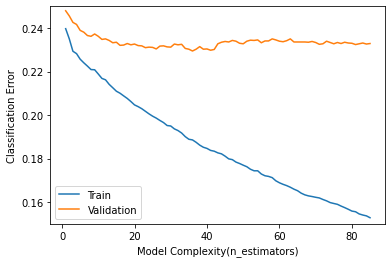

In [14]:
import matplotlib.pyplot as plt

results = model.evals_result()  #각 평가 세트에 대한 모델의 성능 함수.
train_error = results['validation_0']['error']  #evals_result() 에 접근할 때.
val_error = results['validation_1']['error']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity(n_estimators)')
plt.ylim((0.15,0.25))
plt.legend(); # 그래프에 범례 추가하기

# 하이퍼파라미터 튜닝의 꿀팁

http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/

1.2.1.1  Random Forest
max_depth (높은값에서 감소시키며 튜닝, 너무 깊어지면 과적합)
n_estimators (적을경우 과소적합, 높을경우 긴 학습시간)
min_samples_leaf (과적합일경우 높임)
max_features (줄일 수록 다양한 트리생성, 높이면 같은 특성을 사용하는 트리가 많아져 다양성이 감소)
class_weight (imbalanced 클래스인 경우 시도)


1.2.1.2  XGBoost
learning_rate (높을경우 과적합 위험이 있습니다)
max_depth (낮은값에서 증가시키며 튜닝, 너무 깊어지면 과적합위험, -1 설정시 제한 없이 분기, 특성이 많을 수록 깊게 설정)
n_estimators (너무 크게 주면 긴 학습시간, early_stopping_rounds와 같이 사용)
scale_pos_weight (imbalanced 문제인 경우 적용시도)
